In [1]:
### Packages

using LinearAlgebra
using JLD
using QuadGK
using Statistics
using PyCall
using PyPlot
using LaTeXStrings
using GadgetIO
using GadgetUnits
using GadgetGalaxies
using UnitfulAstro
using Missings

In [2]:
# Initial Parameters
snap_id = 136

# Derived
filepath = "/HydroSims/Magneticum/Box4/uhr_test/groups_$snap_id/sub_$snap_id"

"/HydroSims/Magneticum/Box4/uhr_test/groups_136/sub_136"

In [3]:
# Functions

# Rotate two vectors in a way that the third dimension is 0 for both
# sfc: check consistencies: Lengths, Angles
function nozaxis(vone,vtwo)
    start   = vone × vtwo
    start   = start ./ norm(start)
    finish  = [0,0,1]
    #fps     = finish+start

    vx      =  start × finish
    #println(vx)
    cx      = transpose(start) * finish
    Vx      = [0 -vx[3] vx[2]; vx[3] 0 -vx[1]; -vx[2] vx[1] 0]
    R = I + Vx + (Vx * Vx ./ (1+cx))

    return R*vone, R*vtwo
end

# Calculate the orbital angular momentum with respect to the central subhalo
# sfc: WARNING! This does not feel right. instead, it should be necessary to calculate everything with respect to the common center of mass
function orbit_j(subpos, subvel, cenpos, cenvel)
    return (subpos .- cenpos) × (subvel .- cenvel)
end


# Calculate Total Halo velocity
function halo_vel(m_ar, vel_ar)
    tot_vel = zeros(3)
    for i in 1:length(m_ar)
        tot_vel += m_ar[i] .* vel_ar[:,i]
    end
    tot_vel ./= sum(m_ar)
    return tot_vel
end

halo_vel (generic function with 1 method)

In [4]:
# Read in

nsub        = read_subfind(filepath, "NSUB")
spinvecs    = read_subfind(filepath, "SPIN")
masses      = read_subfind(filepath, "MSUB")
smst        = read_subfind(filepath, "SMST")
spos        = read_subfind(filepath, "SPOS")
svel        = read_subfind(filepath, "SVEL")
scm         = read_subfind(filepath, "SCM")
mtot        = read_subfind(filepath, "MTOT")
gpos        = read_subfind(filepath, "GPOS")


# Check vectors
println("NSUB vector shape: ", size(nsub))
println("NSUB sum: ", sum(nsub))
println("SPIN vector shape: ", size(spinvecs))
println("SMST vector shape: ", size(smst))
println("SPOS vector shape: ", size(spos))
println("SVEL vector shape: ", size(svel))
println("SCM vector shape: ", size(scm))
println("MTOT vector shape: ", size(mtot))
println("GPOS vector shape: ", size(gpos))

println(Statistics.mean(spos .- scm))
println(Statistics.maximum(spos .- scm))
println(Statistics.minimum(spos .- scm))
println(Statistics.std(spos .- scm))

#for i in 1:length(spos[1,:])
    #println(Statistics.mean(spos[:,i] .- scm[:,i]))
#end


NSUB vector shape: (148471,)
NSUB sum: 166479
SPIN vector shape: (3, 166479)
SMST vector shape: (6, 166479)
SPOS vector shape: (3, 166479)
SVEL vector shape: (3, 166479)
SCM vector shape: (3, 166479)
MTOT vector shape: (148471,)
GPOS vector shape: (3, 148471)
-1.1494462
47998.844
-47998.848
332.64737


In [5]:
# Counting all the empty entries in nsub

nsubzeros = 0
for i in 1:length(nsub)
    if nsub[i] == 0
        nsubzeros += 1
    end
end

println(nsubzeros)


14098


In [6]:
# Processing

spins           = zeros(length(spinvecs[1,:]))
out_spins       = zeros(length(spins) - length(nsub) + nsubzeros)
out_masses      = zeros(length(spins) - length(nsub) + nsubzeros)
central_spins   = zeros(length(nsub))
central_masses  = zeros(length(nsub))
neighbors       = zeros(length(spins))
out_neighbors   = zeros(length(out_spins))
spin_stats      = zeros(2, length(nsub))
out_spin_stats  = zeros(2, length(nsub))
dmmasses        = smst[2,:]

central_spinvecs    = zeros(3, length(nsub))
sum_out_spinvecs    = zeros(3, length(nsub))
sum_out_orbitvecs   = zeros(3,length(nsub))
#sum_out_orbitvecs   = missings(Float64, 3, length(nsub))
sum_out_orbits      = missings(Float64, length(nsub))
sum_out_spins       = zeros(length(nsub))
halo_vels           = zeros(3, length(nsub))



for i in 1:length(spins)
    spins[i] = norm(spinvecs[:,i])
end

ct_missing = 0
k = 0
for i in 1:length(nsub)
    central_spins[i]        = spins[k+1]
    central_masses[i]       = dmmasses[k+1]
    if dmmasses[k+1] > 0.0
        central_spinvecs[:,i]   = spinvecs[:,k+1] ./ dmmasses[k+1]
    end
    for j in 1:nsub[i]
        neighbors[j+k] = nsub[i] - 1
        if j > 1
            out_spins[j+k-i]        = spins[j+k]
            out_masses[j+k-i]       = dmmasses[j+k]
            out_neighbors[j+k-i]    = neighbors[j+k]
            if dmmasses[j+k] > 0.0
                sum_out_spinvecs[:,i]  += spinvecs[:,j+k] ./ dmmasses[j+k]
            end
            sum_out_orbitvecs[:,i] += orbit_j(spos[:,j+k], svel[:,j+k], spos[:,1+k], svel[:,1+k])
            if count(ismissing, sum_out_orbitvecs[:,i]) > 0
                ct_missing += 1
            end
        end
    end
    sum_out_spins[i]        = norm(sum_out_spinvecs[:,i])
    sum_out_orbits[i]       = norm(sum_out_orbitvecs[:,i])
    spin_stats[1, i]        = Statistics.mean(spins[k+1:k+nsub[i]])
    spin_stats[2, i]        = Statistics.std(spins[k+1:k+nsub[i]])
    out_spin_stats[1, i]    = Statistics.mean(spins[k+2:k+nsub[i]])
    out_spin_stats[2, i]    = Statistics.std(spins[k+2:k+nsub[i]])
    halo_vels[:,i]          = halo_vel(dmmasses[k+1:k+nsub[i]], svel[:,k+1:k+nsub[i]])
    
    k += nsub[i]
end


# Check vectors
println("Absolute spin vector shape: ", size(spins))
println("Neighbors vector shape: ", size(neighbors))
println("Spin stats vector shape: ", size(spin_stats))
println("Outer spins shape: ", size(out_spins))
println(count(ismissing, sum_out_orbitvecs))
println(ct_missing)
println(count(ismissing, sum_out_orbitvecs)/ct_missing)



Absolute spin vector shape: (166479,)
Neighbors vector shape: (166479,)
Spin stats vector shape: (2, 148471)
Outer spins shape: (32106,)
0
0
NaN


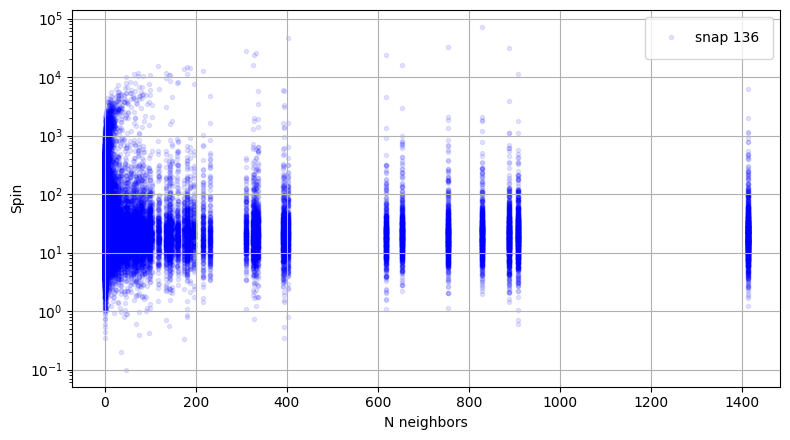

In [7]:
# Plotting spin vs neighbors

fig, ax = subplots()

ax.plot(neighbors, spins, "b.", label="snap $snap_id", alpha= 0.1, zorder = 1)

ax.set_xlabel("N neighbors")
ax.set_ylabel("Spin")
#ax.set_xbound(0,100)
#ax.set_xscale("log")
ax.set_yscale("log")
ax.legend(loc="upper right", frameon=true, borderpad=1, handlelength=1.8)
ax.grid()

scale=0.5

fig.set_size_inches(16scale, 9scale)
fig.tight_layout()
#fig.savefig(joinpath(@__DIR__, "test.pdf"), bbox_inches="tight", pad_inches=.1)

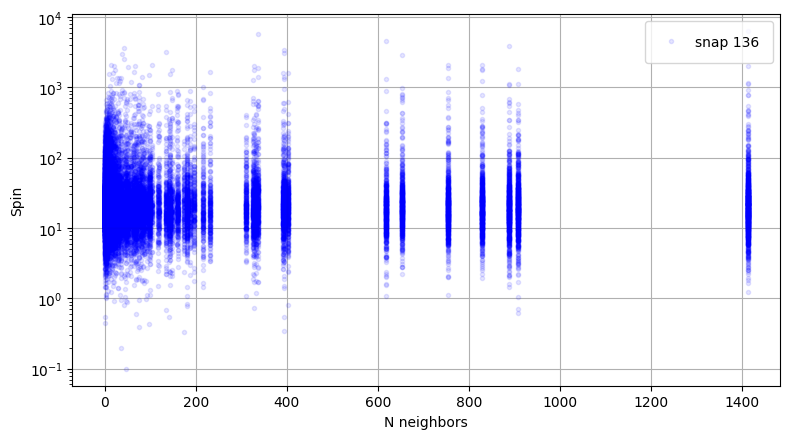

In [8]:
# Plotting without central subhalo

fig, ax = subplots()

ax.plot(out_neighbors, out_spins, "b.", label="snap $snap_id", alpha= 0.1)

ax.set_xlabel("N neighbors")
ax.set_ylabel("Spin")
ax.set_yscale("log")
ax.legend(loc="upper right", frameon=true, borderpad=1, handlelength=1.8)
ax.grid()

scale=0.5

fig.set_size_inches(16scale, 9scale)
fig.tight_layout()

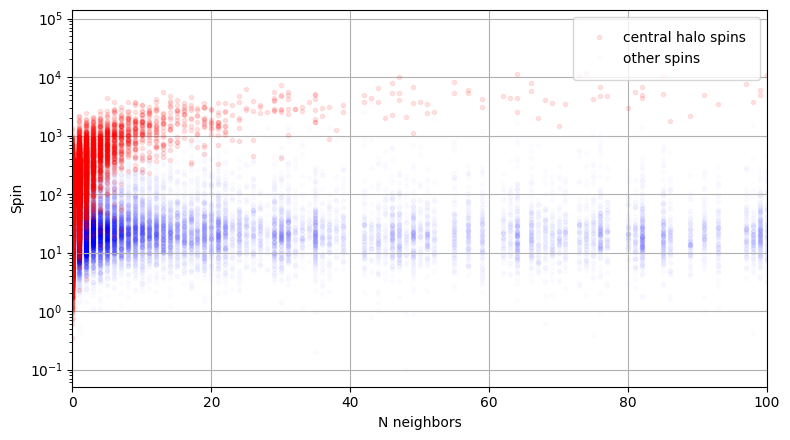

In [9]:
# Plotting central and outer separately

fig, ax = subplots()

ax.plot(nsub .- 1, central_spins, "r.", label="central halo spins", alpha= 0.1, zorder = 2)
ax.plot(out_neighbors, out_spins, "b.", label="other spins", alpha= 0.01, zorder = 1)

ax.set_xlabel("N neighbors")
ax.set_ylabel("Spin")
ax.set_xbound(0,100)
#ax.set_xscale("log")
ax.set_yscale("log")
ax.legend(loc="upper right", frameon=true, borderpad=1, handlelength=1.8)
ax.grid()

scale=0.5

fig.set_size_inches(16scale, 9scale)
fig.tight_layout()

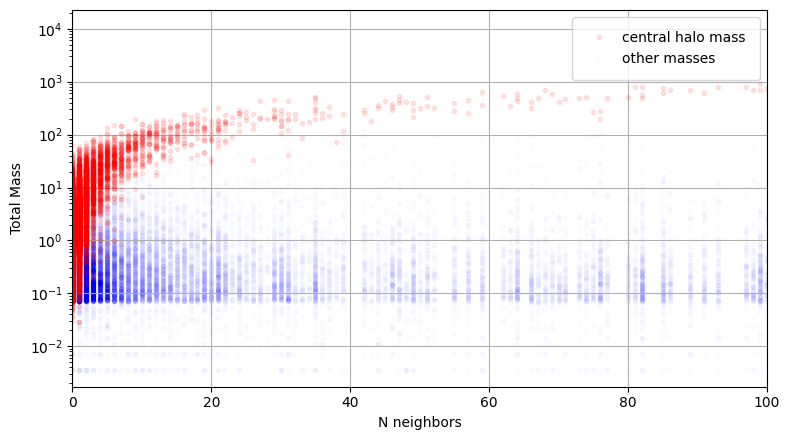

In [10]:
# Plotting the masses of the subhalos respectively

fig, ax = subplots()

ax.plot(nsub .- 1, central_masses, "r.", label="central halo mass", alpha= 0.1, zorder = 2)
ax.plot(out_neighbors, out_masses, "b.", label="other masses", alpha= 0.01, zorder = 1)

ax.set_xlabel("N neighbors")
ax.set_ylabel("Total Mass")
ax.set_xbound(0,100)
#ax.set_xscale("log")
ax.set_yscale("log")
ax.legend(loc="upper right", frameon=true, borderpad=1, handlelength=1.8)
ax.grid()

scale=0.5

fig.set_size_inches(16scale, 9scale)
fig.tight_layout()

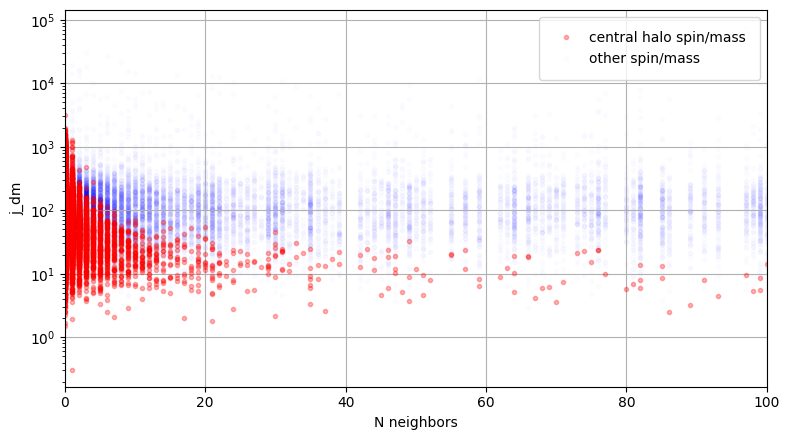

In [11]:
# Plotting divided by the mass

fig, ax = subplots()

ax.plot(nsub .- 1, central_spins ./ central_masses, "r.", label="central halo spin/mass", alpha= 0.3, zorder = 2)
ax.plot(out_neighbors, out_spins ./ out_masses, "b.", label="other spin/mass", alpha= 0.01, zorder = 1)

ax.set_xlabel("N neighbors")
ax.set_ylabel("j_dm")
ax.set_xbound(0,100)
#ax.set_xscale("log")
ax.set_yscale("log")
ax.legend(loc="upper right", frameon=true, borderpad=1, handlelength=1.8)
ax.grid()

scale=0.5

fig.set_size_inches(16scale, 9scale)
fig.tight_layout()

# sfc: slight downward trend for the central halo?

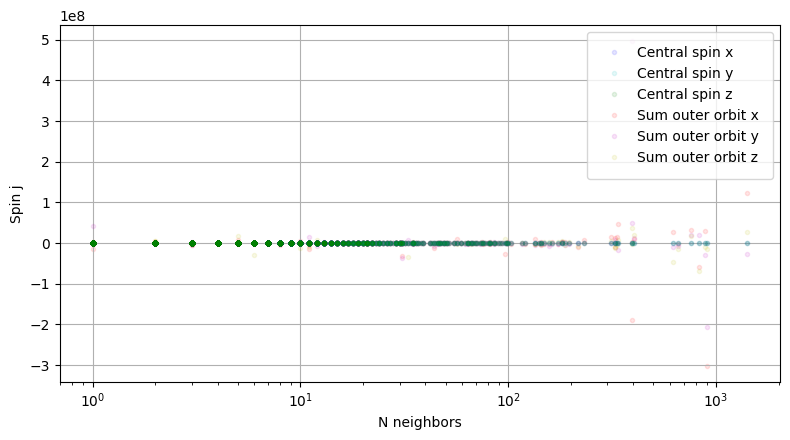

In [12]:
# Plotting central and sum of outer orbit spin vectors

fig, ax = subplots()

ax.plot(nsub .- 1, central_spinvecs[1,:], "b.", label="Central spin x", alpha=0.1, zorder = 5)
ax.plot(nsub .- 1, central_spinvecs[2,:], "c.", label="Central spin y", alpha=0.1, zorder = 6)
ax.plot(nsub .- 1, central_spinvecs[3,:], "g.", label="Central spin z", alpha=0.1, zorder = 7)
ax.plot(nsub .- 1, sum_out_orbitvecs[1,:], "r.", label="Sum outer orbit x", alpha=0.1, zorder = 1)
ax.plot(nsub .- 1, sum_out_orbitvecs[2,:], "m.", label="Sum outer orbit y", alpha=0.1, zorder = 2)
ax.plot(nsub .- 1, sum_out_orbitvecs[3,:], "y.", label="Sum outer orbit z", alpha=0.1, zorder = 3)

ax.set_xlabel("N neighbors")
ax.set_ylabel("Spin j")
#ax.set_xbound(0,100)
ax.set_xscale("log")
#ax.set_yscale("log")
ax.legend(loc="upper right", frameon=true, borderpad=1, handlelength=1.8)
ax.grid()

scale=0.5

fig.set_size_inches(16scale, 9scale)
fig.tight_layout()

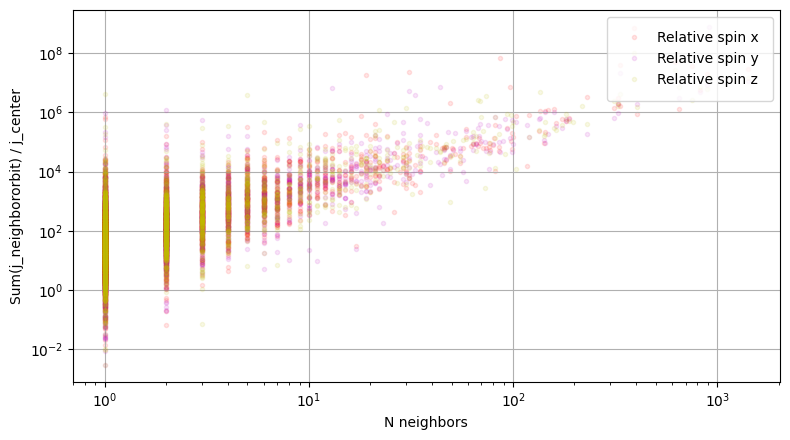

In [13]:
# Plotting outer sum / central

fig, ax = subplots()

ax.plot(nsub .- 1, sum_out_orbitvecs[1,:] ./ central_spinvecs[1,:], "r.", label="Relative spin x", alpha=0.1, zorder = 1)
ax.plot(nsub .- 1, sum_out_orbitvecs[2,:] ./ central_spinvecs[2,:], "m.", label="Relative spin y", alpha=0.1, zorder = 2)
ax.plot(nsub .- 1, sum_out_orbitvecs[3,:] ./ central_spinvecs[3,:], "y.", label="Relative spin z", alpha=0.1, zorder = 3)

ax.set_xlabel("N neighbors")
ax.set_ylabel("Sum(j_neighbororbit) / j_center")
#ax.set_xbound(0,100)
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend(loc="upper right", frameon=true, borderpad=1, handlelength=1.8)
ax.grid()

scale=0.5

fig.set_size_inches(16scale, 9scale)
fig.tight_layout()

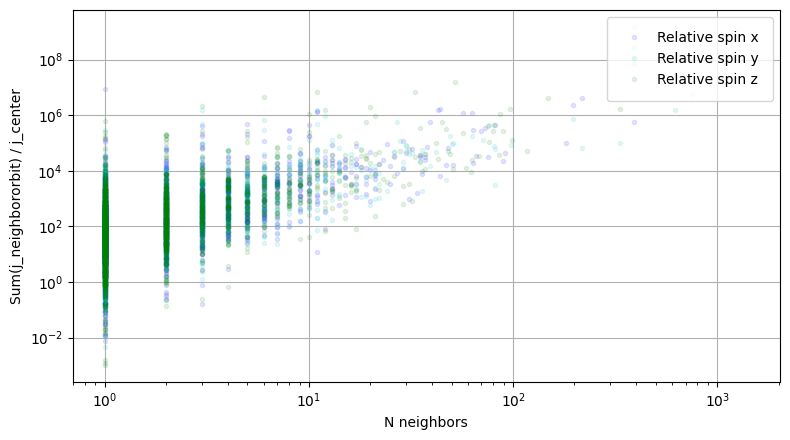

In [14]:
# Plotting outer sum / central * -1

fig, ax = subplots()

ax.plot(nsub .- 1, (-1).* sum_out_orbitvecs[1,:] ./ central_spinvecs[1,:], "b.", label="Relative spin x", alpha=0.1, zorder = 1)
ax.plot(nsub .- 1, (-1).* sum_out_orbitvecs[2,:] ./ central_spinvecs[2,:], "c.", label="Relative spin y", alpha=0.1, zorder = 2)
ax.plot(nsub .- 1, (-1).* sum_out_orbitvecs[3,:] ./ central_spinvecs[3,:], "g.", label="Relative spin z", alpha=0.1, zorder = 3)

ax.set_xlabel("N neighbors")
ax.set_ylabel("Sum(j_neighbororbit) / j_center")
#ax.set_xbound(0,100)
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend(loc="upper right", frameon=true, borderpad=1, handlelength=1.8)
ax.grid()

scale=0.5

fig.set_size_inches(16scale, 9scale)
fig.tight_layout()

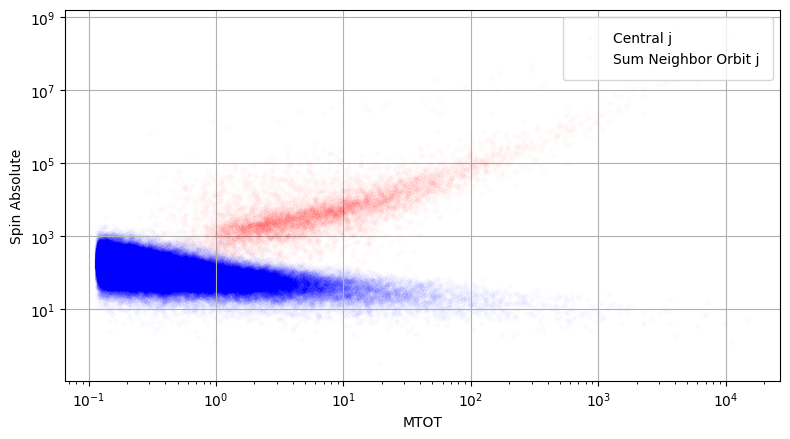

In [15]:
# Plotting outer sum and central absolutes

fig, ax = subplots()

#ax.plot(nsub .- 1, central_spins ./ central_masses, "b.", label="Central j", alpha=0.1, zorder = 1)
#ax.plot(nsub .- 1, sum_out_orbits, "r.", label="Sum Neighbor Orbit j", alpha=0.1, zorder = 2)
ax.plot(mtot, central_spins ./ central_masses, "b.", label="Central j", alpha=0.01, zorder = 1)
ax.plot(mtot, sum_out_orbits, "r.", label="Sum Neighbor Orbit j", alpha=0.01, zorder = 2)

ax.set_xlabel("MTOT")
ax.set_ylabel("Spin Absolute")
#ax.set_xbound(0,100)
#ax.set_ybound(0,1e5)
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend(loc="upper right", frameon=true, borderpad=1, handlelength=1.8)
ax.grid()

scale=0.5

fig.set_size_inches(16scale, 9scale)
fig.tight_layout()

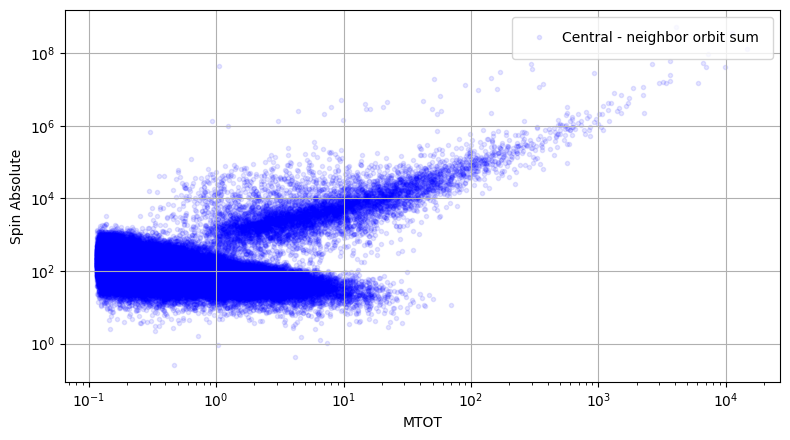

In [16]:
# Plotting outer sum and central absolutes

fig, ax = subplots()

ax.plot(mtot, abs.((central_spins ./ central_masses) .- sum_out_orbits), "b.", label="Central - neighbor orbit sum", alpha=0.1, zorder = 1)

ax.set_xlabel("MTOT")
ax.set_ylabel("Spin Absolute")
#ax.set_xbound(0,100)
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend(loc="upper right", frameon=true, borderpad=1, handlelength=1.8)
ax.grid()

scale=0.5

fig.set_size_inches(16scale, 9scale)
fig.tight_layout()

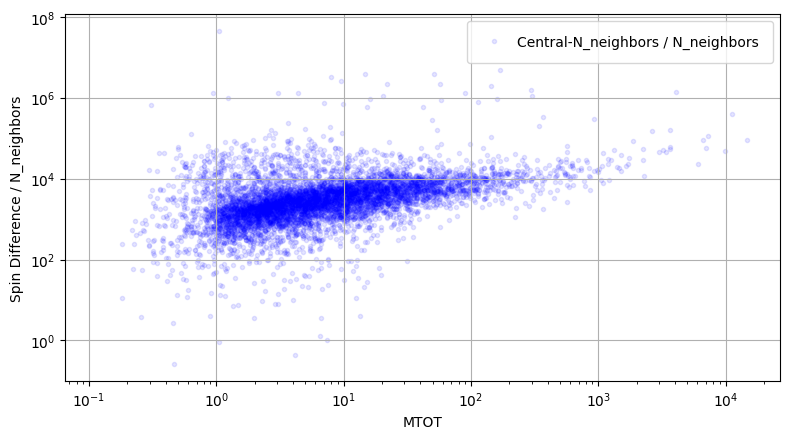

In [17]:
# Plotting outer sum and central absolutes

fig, ax = subplots()

ax.plot(mtot, abs.((central_spins ./ central_masses) .- sum_out_orbits) ./ (nsub .- 1), "b.", label="Central-N_neighbors / N_neighbors", alpha=0.1, zorder = 1)

ax.set_xlabel("MTOT")
ax.set_ylabel("Spin Difference / N_neighbors")
#ax.set_xbound(0,100)
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend(loc="upper right", frameon=true, borderpad=1, handlelength=1.8)
ax.grid()

scale=0.5

fig.set_size_inches(16scale, 9scale)
fig.tight_layout()

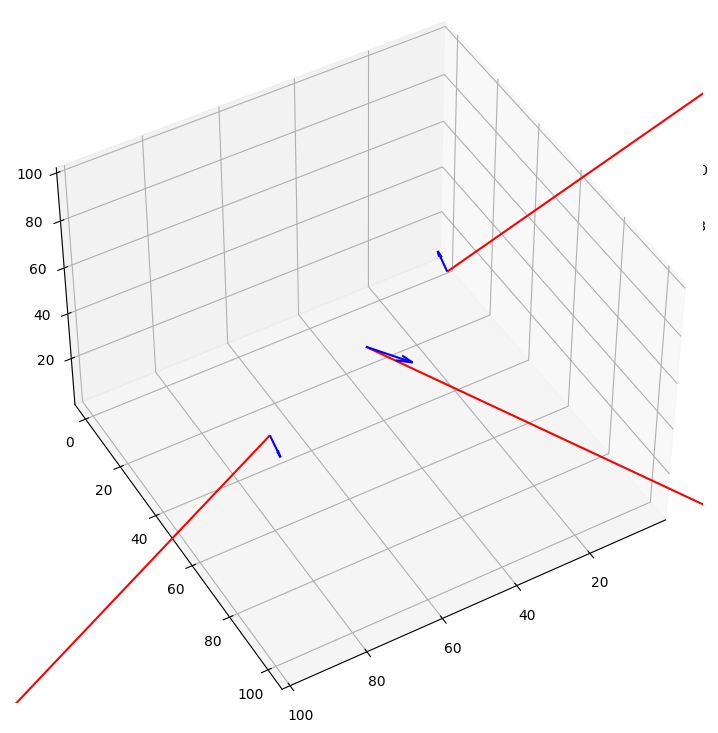

"ax2 = fig.add_subplot(projection=\"3d\")\nax2.view_init(elev=0, azim=90)\nax2.quiver(x, y, z, \n        central_spinvecs[1,start_group:start_group+n_entries-1], \n        central_spinvecs[2,start_group:start_group+n_entries-1], \n        central_spinvecs[3,start_group:start_group+n_entries-1], \n        length=1.0, color = \"blue\", normalize=true)\nax2.quiver(x, y, z, \n        sum_out_orbitvecs[1,start_group:start_group+n_entries-1], \n        sum_out_orbitvecs[2,start_group:start_group+n_entries-1], \n        sum_out_orbitvecs[3,start_group:start_group+n_entries-1], \n        length=1.0, color = \"red\", normalize=true)\n#"

In [18]:


start_group = 4
n_entries = 3
scale = 100

fig = figure(figsize=(16,9))
ax1 = fig.add_subplot(projection="3d")

x = LinRange(1, scale, n_entries)
y = LinRange(1, scale, n_entries)
z = LinRange(1, scale, n_entries)


ax1 = fig.add_subplot(projection="3d")
ax1.view_init(elev=45, azim=60)
ax1.set_xlim3d(1,scale)

ax1.quiver3D(x, y, z, 
        central_spinvecs[1,start_group:start_group+n_entries-1], 
        central_spinvecs[2,start_group:start_group+n_entries-1], 
        central_spinvecs[3,start_group:start_group+n_entries-1], 
        color = "blue", normalize=false, label="central")
        #length=0.1, color = "blue", normalize=false)
ax1.quiver3D(x, y, z, 
        sum_out_orbitvecs[1,start_group:start_group+n_entries-1], 
        sum_out_orbitvecs[2,start_group:start_group+n_entries-1], 
        sum_out_orbitvecs[3,start_group:start_group+n_entries-1], 
        color = "red", normalize=false)
        #length=0.1, color = "red", normalize=false)

"""
ax2 = fig.add_subplot(projection="3d")
ax2.view_init(elev=0, azim=90)
ax2.quiver(x, y, z, 
        central_spinvecs[1,start_group:start_group+n_entries-1], 
        central_spinvecs[2,start_group:start_group+n_entries-1], 
        central_spinvecs[3,start_group:start_group+n_entries-1], 
        length=1.0, color = "blue", normalize=true)
ax2.quiver(x, y, z, 
        sum_out_orbitvecs[1,start_group:start_group+n_entries-1], 
        sum_out_orbitvecs[2,start_group:start_group+n_entries-1], 
        sum_out_orbitvecs[3,start_group:start_group+n_entries-1], 
        length=1.0, color = "red", normalize=true)
#"""

#fig.tight_layout()


In [19]:



a = [5,9,-2]
b = [4,5,6]

a2, b2 = nozaxis(a,b)


println(a, "   ---   ", a2)
println(b, "   ---   ", b2)

[5, 9, -2]   ---   [6.992539892537915, 7.816929438805611, 0.0]
[4, 5, 6]   ---   [-1.9776196776137507, 8.549211683583163, 8.881784197001252e-16]


In [20]:
noz_cen_spinvecs    = zeros(3,length(nsub))
noz_sumout_spinvecs = zeros(3,length(nsub))

for i in 1:length(nsub)
    noz_cen_spinvecs[:,i], noz_sumout_spinvecs[:,i] = nozaxis(central_spinvecs[:,i], sum_out_orbitvecs[:,i])
end

noz_cen_spinvecs    = noz_cen_spinvecs[1:2,:]
noz_sumout_spinvecs = noz_sumout_spinvecs[1:2,:]

println(size(noz_cen_spinvecs))
println(size(noz_sumout_spinvecs))

(2, 148471)
(2, 148471)


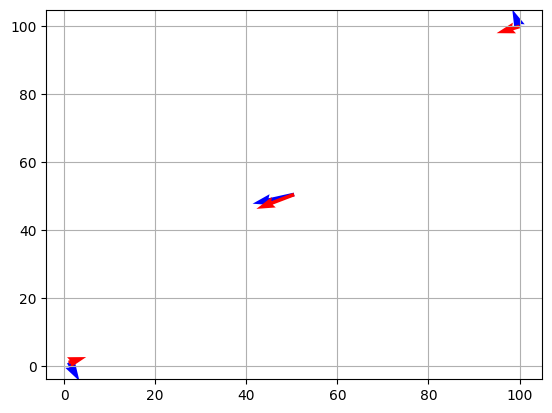

[3.7540199784024093, -6.4496507241814545]   ---   [4.032536992582843e7, 1.2416840737394927e7]
[-14.350755871971069, -3.189785857288844]   ---   [-8.668649508665687e7, -3.311039603760659e7]
[-2.51645946711087, 5.909775132793013]   ---   [-5.2813359379161105e7, -1.5382430650323208e7]


In [21]:
#plot quiver


start_group = 4
n_entries = 3
scale = 100

end_group = start_group+n_entries-1

for i in start_group:end_group
        println(noz_cen_spinvecs[:,i], "   ---   ", noz_sumout_spinvecs[:,i])
end


#fig = figure(figsize=(16,9))
#ax1 = fig.add_subplot()

x = LinRange(1, scale, n_entries)
y = LinRange(1, scale, n_entries)

fig1, ax1 = subplots()
#ax1.set_title('Arrows scale with figure')

#ax1.set_xlim(1,scale)

ax1.quiver(x,y, 
        noz_cen_spinvecs[1,start_group:end_group],
        noz_cen_spinvecs[2,start_group:end_group],
        color="blue")

ax1.quiver(x,y, 
        noz_sumout_spinvecs[1,start_group:end_group],
        noz_sumout_spinvecs[2,start_group:end_group],
        color="red")

ax1.grid()

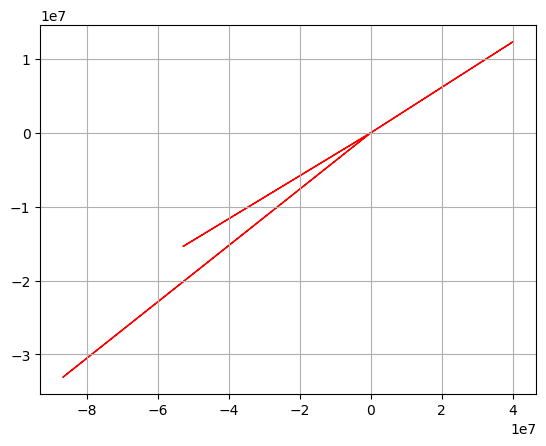

[3.7540199784024093, -6.4496507241814545]   ---   [4.032536992582843e7, 1.2416840737394927e7]
[-14.350755871971069, -3.189785857288844]   ---   [-8.668649508665687e7, -3.311039603760659e7]
[-2.51645946711087, 5.909775132793013]   ---   [-5.2813359379161105e7, -1.5382430650323208e7]


In [22]:
#plot arrow


start_group = 4
n_entries = 3
scale = 100

end_group = start_group+n_entries-1

for i in start_group:end_group
        println(noz_cen_spinvecs[:,i], "   ---   ", noz_sumout_spinvecs[:,i])
end


x = LinRange(1, scale, n_entries)
y = LinRange(1, scale, n_entries)

fig1, ax1 = subplots()

for i in start_group:end_group
        ax1.arrow(i,0,noz_cen_spinvecs[1,i],noz_cen_spinvecs[2,i], width=0.05, color="blue", head_width=0.5)
        ax1.arrow(i,0,noz_sumout_spinvecs[1,i],noz_sumout_spinvecs[2,i], width=0.05, color="red", head_width=0.5)
end

ax1.grid()

In [23]:
angles_cen_outsum = zeros(length(nsub))

for i in 1:length(nsub)
    #println((transpose(central_spinvecs[:,i])*sum_out_orbitvecs[:,i]) / norm(central_spinvecs[:,i]) / norm(sum_out_orbitvecs[:,i]))
    angles_cen_outsum[i] = 180/π*acos((transpose(central_spinvecs[:,i])*sum_out_orbitvecs[:,i]) / norm(central_spinvecs[:,i]) / norm(sum_out_orbitvecs[:,i]))
end

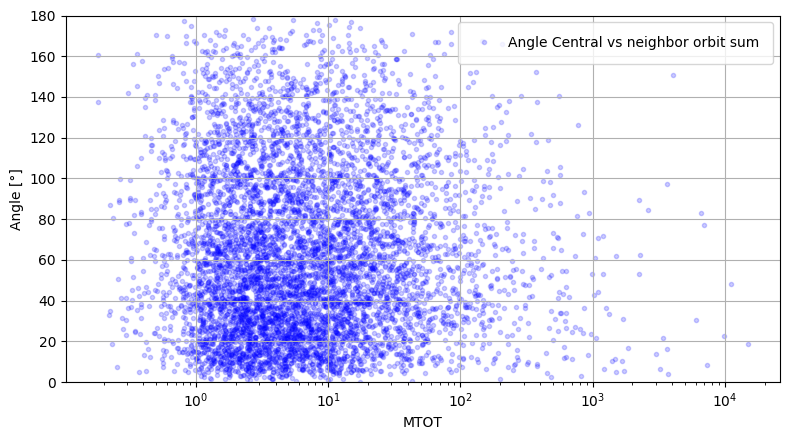

In [24]:
# Plot angle between central spin and subhalo spin sum vs mass

fig, ax = subplots()

ax.plot(mtot, angles_cen_outsum, "b.", label="Angle Central vs neighbor orbit sum", alpha=0.2, zorder = 1)

ax.set_xlabel("MTOT")
ax.set_ylabel("Angle [°]")
#ax.set_xbound(0,100)
ax.set_ybound(0,180)
ax.set_xscale("log")
#ax.set_yscale("log")
ax.legend(loc="upper right", frameon=true, borderpad=1, handlelength=1.8)
ax.grid()

scale=0.5

fig.set_size_inches(16scale, 9scale)
fig.tight_layout()

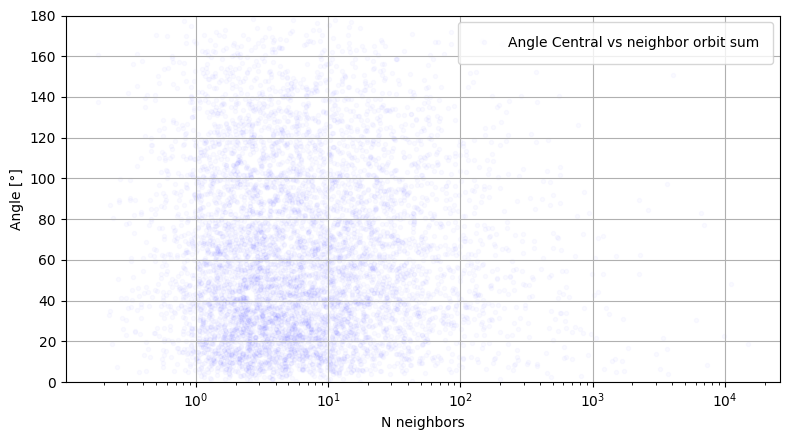

In [25]:
# Plot angle between central spin and subhalo spin sum vs mass

fig, ax = subplots()

ax.plot(mtot, angles_cen_outsum, "b.", label="Angle Central vs neighbor orbit sum", alpha=0.02, zorder = 1)

ax.set_xlabel("N neighbors")
ax.set_ylabel("Angle [°]")
#ax.set_xbound(0,100)
ax.set_ybound(0,180)
ax.set_xscale("log")
#ax.set_yscale("log")
ax.legend(loc="upper right", frameon=true, borderpad=1, handlelength=1.8)
ax.grid()

scale=0.5

fig.set_size_inches(16scale, 9scale)
fig.tight_layout()

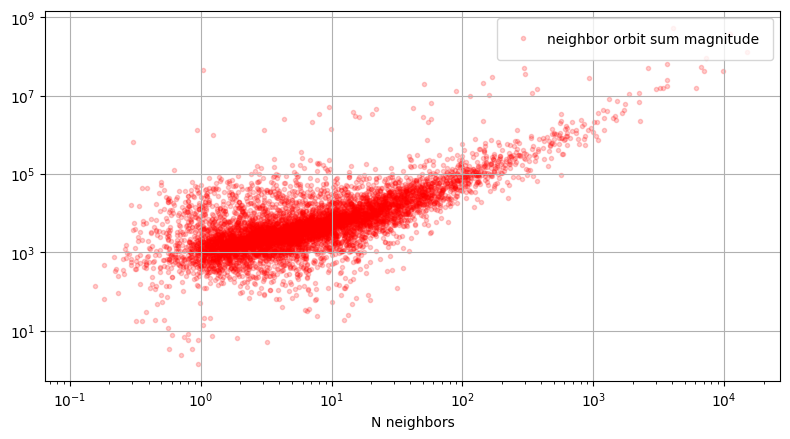

In [26]:
# Plot angle between central spin and subhalo spin sum vs N neighbors

fig, ax = subplots()

ax.plot(mtot, norm.(sum_out_orbits), "r.", label="neighbor orbit sum magnitude", alpha=0.2, zorder = 1)

ax.set_xlabel("N neighbors")
#ax.set_ylabel("Angle [°]")
#ax.set_xbound(0,100)
#ax.set_ybound(0,180)
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend(loc="upper right", frameon=true, borderpad=1, handlelength=1.8)
ax.grid()

scale=0.5

fig.set_size_inches(16scale, 9scale)
fig.tight_layout()